This notebook creates a Recurrent neural network (RNN) to predict bus travel times.

Import packages

In [18]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt
from collections import deque
import random

In [2]:
data = pds.read_pickle('../../added_t_ttjs.pkl')

In [3]:
data.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number,label,t,ttjs
0,1,1,2018-02-16 04:48:40+01:00,ObservedPositionEvent,5432,0,58.414238,15.571015,147.300003,0.0,NaN,1,1,72,71.0,0
1,3,3,2018-02-16 04:48:41+01:00,ObservedPositionEvent,5432,0,58.414246,15.571012,147.300003,0.0,NaN,1,1,72,70.0,0
2,4,4,2018-02-16 04:48:42+01:00,ObservedPositionEvent,5432,0,58.414249,15.571008,147.300003,0.0,NaN,1,1,72,69.0,0
3,5,5,2018-02-16 04:48:43+01:00,ObservedPositionEvent,5432,0,58.414257,15.571004,147.300003,0.0,NaN,1,1,72,68.0,0
4,6,6,2018-02-16 04:48:44+01:00,ObservedPositionEvent,5432,0,58.414257,15.571006,147.300003,0.0,NaN,1,1,72,67.0,0


One hot encode segments, normalize columns and create final dataset

In [4]:
df = data
dataset = pds.DataFrame()
# Make segments categorical
dataset = pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 

dataset['hr_sin'] = np.sin((df.timestamp.dt.hour*3600+df.timestamp.dt.minute*60+df.timestamp.dt.second)*(2.*np.pi/86400))
dataset['hr_cos'] = np.cos((df.timestamp.dt.hour*3600+df.timestamp.dt.minute*60+df.timestamp.dt.second)*(2.*np.pi/86400))

# Convert to radians befor trigonometric functions
dataset['dir_sin'] = np.sin(df.direction*(np.pi/180))
dataset['dir_cos'] = np.cos(df.direction*(np.pi/180))

dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())
# Previously was 'time_since_journey_start'
dataset['ttjs'] = (df['ttjs']-df['ttjs'].min())/(df['ttjs'].max()-df['ttjs'].min())

dataset['latitude'] = (df['latitude']-df['latitude'].min())/(df['latitude'].max()-df['latitude'].min())
dataset['longitude'] = (df['longitude']-df['longitude'].min())/(df['longitude'].max()-df['longitude'].min())

dataset['t'] = df['t']
# Include journey number to select entire journeys
dataset['journey_number'] = df['journey_number']

dataset.head()

,1,2,3,4,5,6,7,8,9,10,...,hr_sin,hr_cos,dir_sin,dir_cos,speed,ttjs,latitude,longitude,t,journey_number
0,1,0,0,0,0,0,0,0,0,0,...,0.951951,0.306249,0.54024,-0.841511,0.0,0.0,0.326317,0.924521,71.0,1
1,1,0,0,0,0,0,0,0,0,0,...,0.951974,0.306180,0.54024,-0.841511,0.0,0.0,0.326237,0.925287,70.0,1
2,1,0,0,0,0,0,0,0,0,0,...,0.951996,0.306111,0.54024,-0.841511,0.0,0.0,0.326156,0.925670,69.0,1
3,1,0,0,0,0,0,0,0,0,0,...,0.952018,0.306041,0.54024,-0.841511,0.0,0.0,0.326076,0.926437,68.0,1
4,1,0,0,0,0,0,0,0,0,0,...,0.952040,0.305972,0.54024,-0.841511,0.0,0.0,0.326116,0.926437,67.0,1


Divide training/validation/test data set

In [5]:
# Roughly 20% Test and 20% Validation
num_test_segments = 700
num_validation_segments = 700
unique_journeys = dataset.journey_number.unique()
random.shuffle(unique_journeys)

msk1 = unique_journeys[0:num_test_segments]
msk2 = unique_journeys[num_test_segments:num_test_segments+num_validation_segments]
msk3 = unique_journeys[num_test_segments+num_validation_segments:len(unique_journeys)]
mask1 = dataset['journey_number'].isin(msk1)
mask2 = dataset['journey_number'].isin(msk2)
mask3 = dataset['journey_number'].isin(msk3)

In [6]:
test_input = dataset[mask1]
validation_input = dataset[mask2]
train_input = (dataset[mask3])

In [7]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey_number'])
test_data = test_input.drop(columns=['journey_number'])
validation_data = validation_input.drop(columns=['journey_number'])

train_data.head()

,1,2,3,4,5,6,7,8,9,10,11,hr_sin,hr_cos,dir_sin,dir_cos,speed,ttjs,latitude,longitude,t
2474,1,0,0,0,0,0,0,0,0,0,0,0.998848,-0.047978,0.551937,-0.833886,0.0,0.0,0.326076,0.922605,187.0
2475,1,0,0,0,0,0,0,0,0,0,0,0.998845,-0.048051,0.551937,-0.833886,0.0,0.0,0.326076,0.922605,186.0
2476,1,0,0,0,0,0,0,0,0,0,0,0.998841,-0.048123,0.551937,-0.833886,0.0,0.0,0.326076,0.922605,185.0
2477,1,0,0,0,0,0,0,0,0,0,0,0.998838,-0.048196,0.551937,-0.833886,0.0,0.0,0.326076,0.922605,184.0
2478,1,0,0,0,0,0,0,0,0,0,0,0.998834,-0.048269,0.551937,-0.833886,0.0,0.0,0.326076,0.922605,183.0


Modify dataset to contain sequences. This is required for the RNN. Each sequence is SEQUENCE_LENGTH consecutive data points. Currently a sequence can contain data points from two different journeys, this is not optimal. Should check if the sequence starts and ends in the same journey.

In [8]:
SEQUENCE_LENGTH = 20
def sequencify(df, shuffle):
    sequencial_data = []
    sequence = deque(maxlen=SEQUENCE_LENGTH)
    for i in df.values:
        sequence.append([n for n in i[:-1]])
        if len(sequence) == SEQUENCE_LENGTH:
            sequencial_data.append([np.array(sequence), i[-1]])
    if shuffle:
        random.shuffle(sequencial_data)
    X = []
    Y = []
    for sequence, label in sequencial_data:
        X.append(sequence)
        Y.append(label)
    return np.array(X),Y

In [9]:
seq_train_x, seq_train_y = sequencify(train_data, True)
seq_test_x, seq_test_y = sequencify(test_data, True)
seq_validation_x, seq_validation_y = sequencify(validation_data, True)

Model creation

In [10]:
BATCH_SIZE = 64
EPOCHS = 5
model = keras.Sequential()
model.add(keras.layers.CuDNNLSTM(128, input_shape=(seq_train_x.shape[1:]), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.CuDNNLSTM(128, input_shape=(seq_train_x.shape[1:]), return_sequences=True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.CuDNNLSTM(128, input_shape=(seq_train_x.shape[1:])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(1))

opt = keras.optimizers.Adadelta()

model.compile(loss='mae',optimizer=opt, metrics=['mae'])

Fit model

In [11]:
result = model.fit(seq_train_x,seq_train_y,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(seq_validation_x,seq_validation_y))

Train on 2027357 samples, validate on 644250 samples
Epoch 1/5
2027357/2027357 [==============================] - 493s 243us/step - loss: 13.0493 - mean_absolute_error: 13.0493 - val_loss: 10.3688 - val_mean_absolute_error: 10.3688
Epoch 2/5
2027357/2027357 [==============================] - 476s 235us/step - loss: 12.4044 - mean_absolute_error: 12.4044 - val_loss: 10.1606 - val_mean_absolute_error: 10.1606
Epoch 3/5
2027357/2027357 [==============================] - 466s 230us/step - loss: 12.2803 - mean_absolute_error: 12.2803 - val_loss: 10.0970 - val_mean_absolute_error: 10.0970
Epoch 4/5
2027357/2027357 [==============================] - 474s 234us/step - loss: 12.2404 - mean_absolute_error: 12.2404 - val_loss: 10.1447 - val_mean_absolute_error: 10.1447
Epoch 5/5
2027357/2027357 [==============================] - 501s 247us/step - loss: 12.2066 - mean_absolute_error: 12.2066 - val_loss: 10.0596 - val_mean_absolute_error: 10.0596


Saving the model to file.

In [20]:
# Serialize weights to HDF5
model.save_weights("model3v2.h5")

Evaluate model on test data

In [12]:
model.evaluate(seq_test_x, seq_test_y)

640336/640336 [==============================] - 92s 143us/step


[9.818086423669207, 9.818086423669207]

Below 10 is pretty promising. When a sequence of 10 instead of 20 was used the MAE was around 11, so about a second improvement.

Lets look at a random journey from the test set. Predictions are green and true values are red.

In [21]:
selected_journey = np.random.choice(msk1)
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
seq_x, seq_y= sequencify(model_to_predict, False)
predictions = model.predict(seq_x, batch_size=1, verbose=1)

882/882 [==============================] - 3s 3ms/step


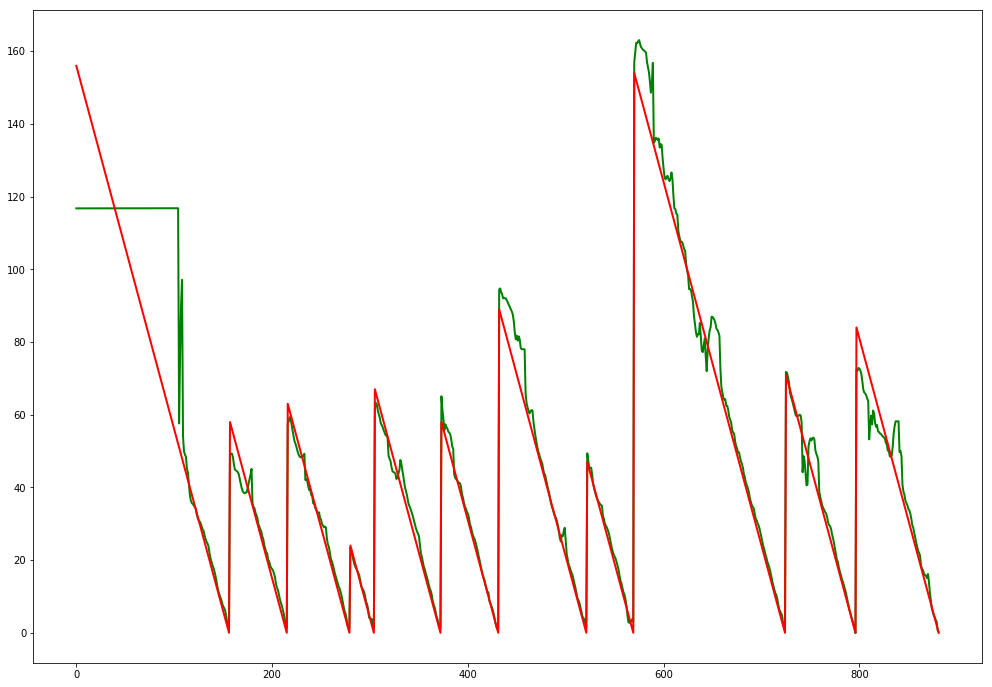

882/882 [==============================] - 0s 148us/step
[6.404536891686403, 6.404536891686403]


In [22]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(seq_y, color='red', linewidth=2, markersize=12)
plt.show()
print(model.evaluate(seq_x, seq_y))

The predictions follow the true values fairly well except for the first segment.

Plot of all test data. True values on the x-axis and predicted values on the y-axis.

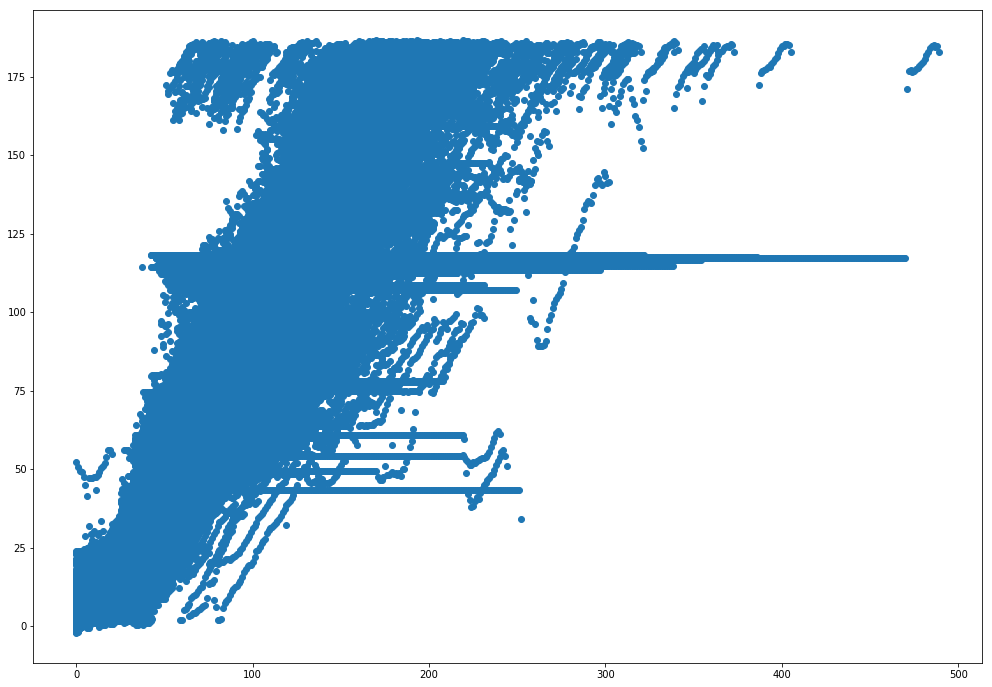

In [15]:
test_predictions = model.predict(seq_test_x)
plt.scatter(seq_test_y, test_predictions)
plt.show()